### Setup

In [115]:
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow_gan.examples.mnist.util import mnist_frechet_distance

from src.sarnet_vae import *
from src.semidense import *
from scipy.ndimage import gaussian_filter


DIGIT = 5

# Load train images
images = np.load("./data/train_images.npy")
labels = np.load("./data/train_labels.npy")
images = images[labels == DIGIT]

# Load test images
test_images = np.load("./data/test_images.npy")
test_labels = np.load("./data/test_labels.npy")
test_images = test_images[test_labels == DIGIT]

# Raw data
raw_data = images
raw_test_data = test_images

# Standarized data
standarized_data = images / 255
standarized_test_data = test_images / 255

### FID

We calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images. We use `mnist_frechet_distance` function from the tensorflow_gan package. TF_GAN is widely used in projects and research at Google.

Unlike the traditional FID calculation, `mnist_frechet_distance` doesn't use the InceptionV3 model. Instead, it uses the TF-GAN MNIST classifier, which has ~99% accuracy. This approach allows for quicker calculations. The function expects the input pixels values to be in the range [-1,1].

In [59]:
def get_fid_score_mnist(generated_images, N, ground_truth_data, replacement=True):
    """
    Calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images.

    Parameters
    ----------
    generated_images : list, numpy.ndarray or torch.tensor
        The generated images to be evaluated. Should be a iterable list of images with shape (N, 28, 28).
    N : int
        The number of images to be used for calculating the FID score.

    Returns
    -------
    float
        The FID score between the generated images and the real MNIST test images.
    """

    # Select N real images from the standardized MNIST test data
    real_images = ground_truth_data.reshape(-1, 1, 28, 28)
    real_images = real_images[np.random.choice(real_images.shape[0], N, replace=replacement)]

    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    real_images = (
        real_images.reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1) - 0.5
    ) * 2
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)

    # Prepare the generated images
    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    gen_x = (
        np.array(generated_images).reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1)
        - 0.5
    ) * 2
    gen_x = tf.convert_to_tensor(gen_x, dtype=tf.float32)

    # Calculate the number of batches for the FID computation
    num_batches = int(np.ceil(N / 500))
    num_batches = max(1, num_batches)
    score = mnist_frechet_distance(real_images, gen_x, num_batches)

    return score

## Experiments

### FID score for the same data

We calculated the FID on the test dataset (~900 samples). We randomly drew 5,000 samples from this dataset with replacement and then calculated the FID score. The score obtained was 0.04879.

- When evaluating sarNET models, we use the test dataset and the same sampling technique with 10,000 samples. This sample size is large enough to ensure that the calculated scores have small variance. We compared drawing 5,000 samples with replacement from the test dataset to drawing 5,000 samples without replacement from the training dataset (which has over 5,000 samples). The results were similar, so we decided to use 10,000 samples drawn with replacement from the test dataset as our ground truth dataset for evaluating sarNET models.

In [ ]:
# drawing 5 000 samples with replacement from test dataset
N = 5000
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]

score = get_fid_score_mnist(generated_images, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f}")

FID score: 0.048791


In [ ]:
# drawing 5 000 samples without replacement from train dataset
N = 5000
generated_images = standarized_data[
    np.random.choice(standarized_data.shape[0], N)
]

score = get_fid_score_mnist(
    generated_images, N, standarized_data, replacement=False
)
print(f"FID score: {float(score):.6f}")

FID score: 0.044765


### FID score for blured data

We compared the FID score for the real dataset and slightly blurred images. The images were blurred using a Gaussian filter, which applies a Gaussian kelner and smooths the images. We found that even slightly blurred images have high FID scores:

- sigma = 1, FID score: 37.053
- sigma = 0.5, FID score: 2.218

In the cell below we demonstrate how the transformation looks.

For a sanity check, we compared the FID scores of data drawn from the test dataset with replacement and drawn from the train dataset without replacement. We obtained similar results.

In [192]:
def blurr_data(data, sigma):
    blurred = np.apply_along_axis(gaussian_filter, axis=1, arr=data, sigma=sigma)
    return blurred

def compare_images(orig, transformed, num, transform_name):
    orig_imgs = orig[:num]
    transformed_imgs = transformed[:num]
    plt.figure(figsize=(12, 3))
    plt.title(f"Original (first row) and {transform_name} images (second row)")
    plt.axis("off")
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.axis("off")
        plt.imshow(orig_imgs[i], cmap="gray")
        plt.subplot(2, 10, 11 + i)
        plt.axis("off")
        plt.imshow(transformed_imgs[i], cmap="gray")

    plt.tight_layout()
    plt.show()

FID score: 37.053265 with sigma parameter = 1


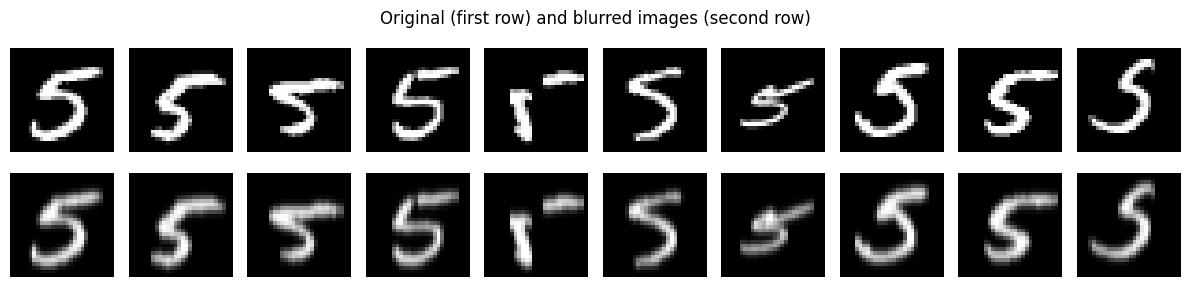

FID score: 2.218389 with sigma parameter = 0.5


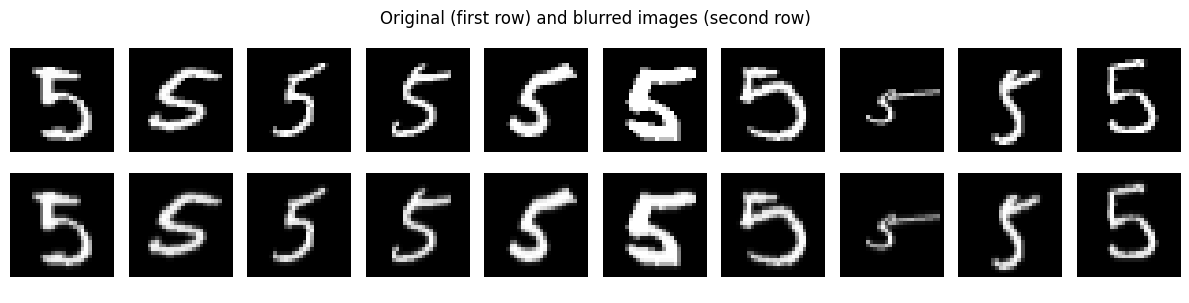

In [148]:
# drawing 5 000 samples with replacement from test dataset
N = 5000
sigma=1
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
blurred_data = blurr_data(generated_images, sigma)

score = get_fid_score_mnist(blurred_data, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with sigma parameter = {sigma}")
compare_images(generated_images, blurred_data, 10, "blurred")

# drawing 5 000 samples with replacement from test dataset
N = 5000
sigma=0.5
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
blurred_data = blurr_data(generated_images, sigma)

score = get_fid_score_mnist(blurred_data, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with sigma parameter = {sigma}")
compare_images(generated_images, blurred_data, 10, "blurred")

In [144]:
# drawing 5 000 samples without replacement from train dataset
N = 5000
sigma = 1
generated_images = standarized_data[
    np.random.choice(standarized_data.shape[0], N)
]
blurred_data = blurr_data(generated_images, sigma)

score = get_fid_score_mnist(
    blurred_data, N, standarized_data, replacement=False
)
print(f"FID score: {float(score):.6f} with sigma parameter = {sigma}")

# drawing 5 000 samples without replacement from train dataset
N = 5000
sigma = 0.5
generated_images = standarized_data[
    np.random.choice(standarized_data.shape[0], N)
]
blurred_data = blurr_data(generated_images, sigma)

score = get_fid_score_mnist(
    blurred_data, N, standarized_data, replacement=False
)
print(f"FID score: {float(score):.6f} with sigma parameter = {sigma}")

FID score: 36.576363 with sigma parameter = 1
FID score: 2.571696 with sigma parameter = 0.5


### FID score for low-diversity data

We compared the FID score for the real dataset with images sampled from the real dataset in a biased manner. Images from the first half of the original dataset were 50% more likely to be drawn than images from the second half. As expected, the diversity of samples has impact on the FID score. In the below experiment, the FID increased approximately tenfold to 0.3698

In [171]:
# drawing 5 000 samples with replacement from test dataset
N = 5000
length = standarized_test_data.shape[0]
p = np.ones(length) / length
p[:(length // 2)] += (1 / (3 * length))
p[(length // 2):] -= (1 / (3 * length))
generated_images = standarized_test_data[
    np.random.choice(standarized_test_data.shape[0], N, p=p)
]

score = get_fid_score_mnist(
    generated_images, N, standarized_test_data, replacement=True
)
print(f"FID score: {float(score):.6f}")

FID score: 0.369806


### FID score for other transformations:

- random perspecitve transformation:
    - FID score: 15.4252 with scale parameter = 0.2
    - FID score: 214.6017 with scale parameter = 0.5

- padding:
    - FID score: 8.0245 with padding parameter = 1
    - FID score: 81.2359 with padding parameter = 5

In [213]:
import torch
from torchvision.transforms import RandomPerspective
from torchvision.transforms import Pad
from torchvision.transforms import Resize

def random_perspective_data(data, scale, p):
    t = RandomPerspective(scale, p)
    data = torch.tensor(data)
    transformed = t(data)
    return transformed.detach().numpy()

def pad_data(data, padding):
    t = Pad(padding)
    r = Resize((28,28))
    data = torch.tensor(data)
    transformed = t(data)
    transformed = r(transformed)
    return transformed.detach().numpy()

FID score: 15.425244 with scale parameter = 0.2


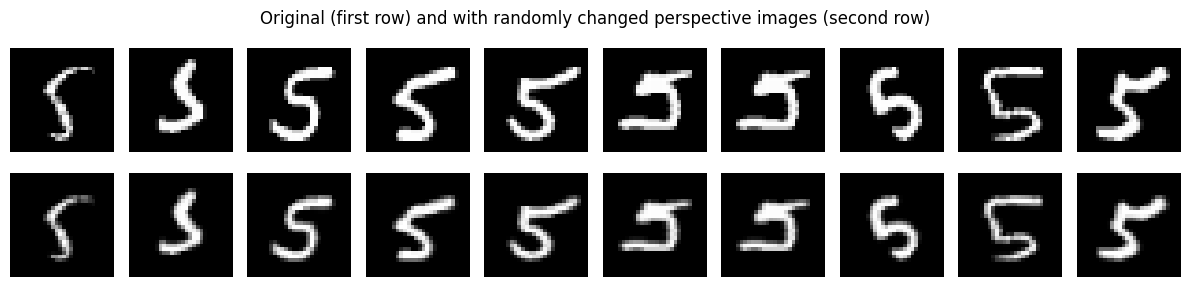

FID score: 214.601791 with scale parameter = 0.5


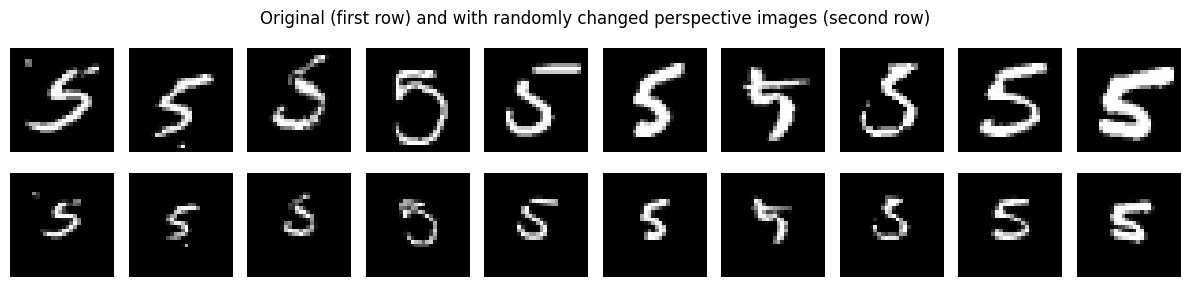

In [224]:
# drawing 5 000 samples with replacement from test dataset
N = 5000
scale=0.2
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
transformed = random_perspective_data(generated_images, scale, 0.5)

score = get_fid_score_mnist(transformed, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with scale parameter = {scale}")
compare_images(generated_images, transformed, 10, "with randomly changed perspective")

# drawing 5 000 samples with replacement from test dataset
N = 5000
scale = 0.5
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
transformed = random_perspective_data(generated_images, scale, 0.5)

score = get_fid_score_mnist(transformed, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with scale parameter = {scale}")
compare_images(generated_images, transformed, 10, "with randomly changed perspective")

FID score: 8.024494 with padding parameter = 1


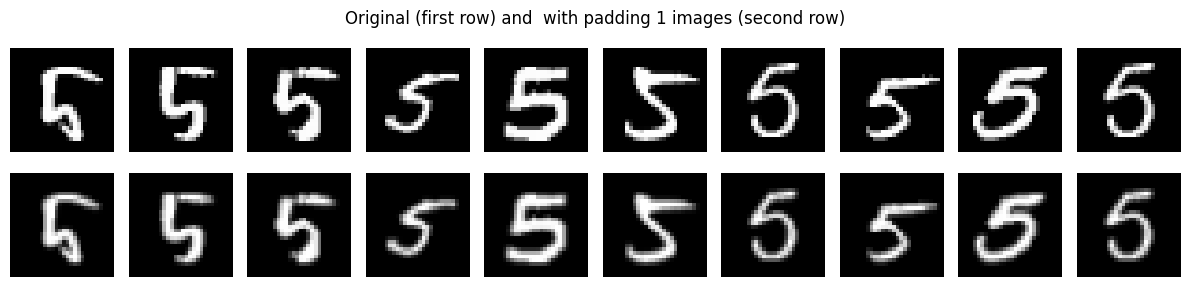

FID score: 81.235939 with padding parameter = 5


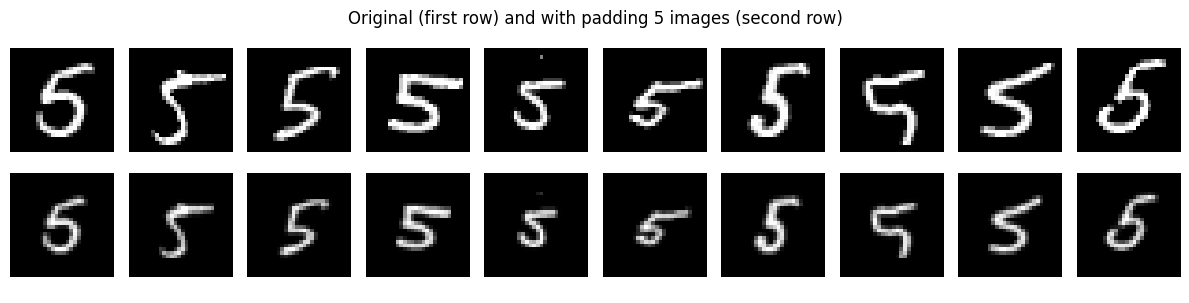

In [225]:
# drawing 5 000 samples with replacement from test dataset
N = 5000
padding = 1
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
transformed = pad_data(generated_images, padding)

score = get_fid_score_mnist(transformed, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with padding parameter = {padding}")
compare_images(generated_images, transformed, 10, f" with padding {padding}")

# drawing 5 000 samples with replacement from test dataset
N = 5000
padding = 5
generated_images = standarized_test_data[
np.random.choice(standarized_test_data.shape[0], N)
]
transformed = pad_data(generated_images, padding)

score = get_fid_score_mnist(transformed, N, standarized_test_data, replacement=True)
print(f"FID score: {float(score):.6f} with padding parameter = {padding}")
compare_images(generated_images, transformed, 10, f"with padding {padding}")